<a href="https://colab.research.google.com/github/JosephBenhar/ANN-/blob/main/CustomerBehaviour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import datetime as dt
%matplotlib inline

In [ ]:
!pip install scikit-mdr scikit-multilearn


In [ ]:
!pip install scikit-mdr

In [ ]:
# importing necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Consumer behaviour.zip",encoding='ISO-8859-1')
df = data.copy()
df.head()

In [ ]:
df.info()

In [ ]:
# Check null values
df.isna().sum()

In [ ]:
# drop null values
df.dropna(inplace=True)
df.isna().sum()

In [ ]:
# check duplicates
df[df.duplicated()].shape

In [ ]:
# Drop duplicated data
df = df.drop_duplicates(keep='first')
df.shape

In [ ]:
# check invoice that contains 'C' which means cancelled
df[df['InvoiceNo'].str.contains('C')]

In [ ]:
# Drop data contains "C" in Invoice
df = df[~df['InvoiceNo'].str.contains('C')]
df.shape

In [ ]:
# Convert 'Quantity' column to float and assign it back to the DataFrame
df['Quantity'] = df['Quantity'].astype('float')

# Change 'InvoiceDate' dtype to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Checking the datatypes after conversion
df.info()

In [ ]:
# Create the 'Revenue' column based on the product of 'Quantity' and 'UnitPrice'
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Display the DataFrame with the newly added 'Revenue' column
print(df.head())

In [ ]:
# Checcking the statsitic of numeric features
df[['Quantity', 'UnitPrice', 'Revenue']].describe().T

In [ ]:
# checking the price column which has a value of 0
df[df['UnitPrice']==0]

In [ ]:
# Remove rows that Price have 0 value from the dataset
df = df[df['UnitPrice']>0]
df.shape

In [ ]:
df.head()

In [ ]:
# checking total order in dataset
df['InvoiceNo'].nunique()

In [ ]:
# checking number of customers
df['CustomerID'].nunique()

In [ ]:
# Checking the number of Quantity sold
df['Quantity'].sum()

In [ ]:
# 20 Customer with the most Quantity Purchases
plt.style.use('dark_background')
df.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False).head(20).plot(kind='bar', color='Blue', figsize=(10,5))
plt.xlabel('CustomerID')
plt.ylabel('Quantity')
plt.title('20 Customer with the most Quantity Purchases', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 20 Customer who generate the most Revenue
df.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).head(20).plot(kind='bar', color='#4f5dff', figsize=(10,5))
plt.xlabel('CustomerID')
plt.ylabel('Revenue')
plt.title('20 Customer who generate the most Revenue', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

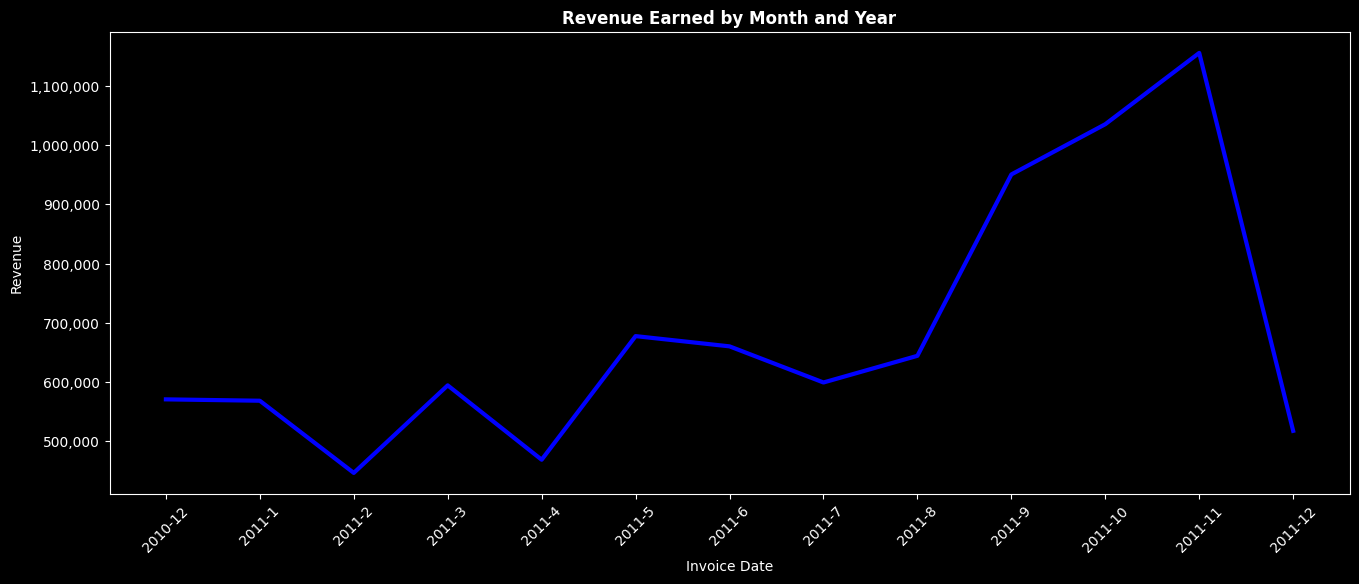

In [ ]:
# Revenue per month and year
monthly_revenue = df.groupby([df['InvoiceDate'].dt.year, df['InvoiceDate'].dt.month])['Revenue'].sum()

# Create a line plot of monthly revenue
ax = monthly_revenue.plot(kind='line', figsize=(16,6), color='Blue', linewidth=3)

# Set xticks and xticklabels to show all values
ax.set_xticks(range(len(monthly_revenue.index)))
ax.set_xticklabels(['{}-{}'.format(year, month) for year, month in monthly_revenue.index], rotation=45)

# Set ylabel format
fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# set title and label
plt.xlabel('Invoice Date')
plt.ylabel('Revenue')
plt.title('Revenue Earned by Month and Year', fontweight='bold')

# Show the plot
plt.show()

In [ ]:
# Checking The Correlation
df[['Quantity','UnitPrice','Revenue']].corr()

In [ ]:
# Visualizing Correlation
sns.heatmap(df[['Quantity','UnitPrice','Revenue']].corr(), annot=True, cmap='vlag')
plt.title('Quantity vs Price vs Revenue')
plt.show()

In [ ]:
df1 = df.drop(['StockCode','Description','Country'], axis=1)
df1.head()

In [ ]:
df1['InvoiceDate'].max()

In [ ]:
max_date = df1['InvoiceDate'].max()
cutoff_timedelta = dt.timedelta(days=90)
cutoff_date = max_date - cutoff_timedelta

In [ ]:
cutoff_date

In [ ]:
before_cutoff = df1[df1['InvoiceDate'] <= cutoff_date]
after_cutoff = df1[df1['InvoiceDate'] > cutoff_date]

In [ ]:
targets = after_cutoff.groupby('CustomerID').sum().rename({'Revenue' : 'total_spend_90'}, axis=1).assign(spend_90 = 1)
targets.drop(['Quantity','UnitPrice'], axis=1, inplace=True)
targets.head()

In [ ]:
targets.shape

In [ ]:
# create analysis date
analysis_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [ ]:
features = before_cutoff.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (analysis_date-InvoiceDate.max()).days,#recency
                              'InvoiceNo': lambda Invoice: Invoice.nunique(),#frequency
                              'Revenue': lambda Revenue: Revenue.sum()#Monetary
                              })

In [ ]:
features.columns = ['recency', 'frequency', 'monetary']

In [ ]:
features

In [ ]:
# Merge features and targets dataframe
features_df = pd.merge(features, targets, how='left', on='CustomerID').fillna(0)
features_df

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
X = features_df.drop(['total_spend_90','spend_90'], axis=1)
X

In [ ]:
y_spend = features_df[['total_spend_90']]
y_spend = y_spend.to_numpy().reshape(-1)
y_spend

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Define pipelines for different models
pipelines = {
    'rf': make_pipeline(RandomForestRegressor(random_state=42)),
    'gb': make_pipeline(GradientBoostingRegressor(random_state=42)),
    'dt': make_pipeline(DecisionTreeRegressor(random_state=42)),
    'xgb': make_pipeline(XGBRegressor(random_state=42)),
    'svm': make_pipeline(SVR()),
    'knn': make_pipeline(KNeighborsRegressor())
}

# You may adjust the hyperparameters or preprocessing steps inside each pipeline as needed

In [ ]:
hypergrid = {
    'rf': {
        'randomforestregressor__min_samples_split': [2, 4, 6],
        'randomforestregressor__min_samples_leaf': [1, 2, 3]
    },
    'gb': {
        'gradientboostingregressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'dt': {
        'decisiontreeregressor__min_samples_split': [2, 4, 6],
        'decisiontreeregressor__min_samples_leaf': [1, 2, 3]
    },
    'xgb': {
        'xgbregressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
        # Add other XGBoost hyperparameters as needed
    },
    'svm': {
        'svr__C': [0.1, 1, 10],
        'svr__gamma': [0.001, 0.01, 0.1, 1]
    },
    'knn': {
        'kneighborsregressor__n_neighbors': [3, 5, 7],
        'kneighborsregressor__weights': ['uniform', 'distance']
    }
}


In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypergrid[algo], cv=5, n_jobs=-1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(X, y_spend)
        fit_models[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for dt.
dt has been successfully fit.
Starting training for xgb.
xgb has been successfully fit.
Starting training for svm.
svm has been successfully fit.
Starting training for knn.
knn has been successfully fit.


In [ ]:
for algo,model in fit_models.items():
    yhat = model.predict(X)
    print('{} scores - R2:{} MAE:{}'.format(algo, r2_score(y_spend, yhat), mean_absolute_error(y_spend, yhat)))

rf scores - R2:0.7968917154756514 MAE:388.4814128355638
gb scores - R2:0.9673363279269482 MAE:437.3379477149177
dt scores - R2:0.6117173878333446 MAE:448.6949951038576
xgb scores - R2:0.953500711319969 MAE:263.311461321718
svm scores - R2:-0.013295290626516909 MAE:793.9639511012513
knn scores - R2:0.4902110369305869 MAE:610.1449418397626


In [ ]:
prediction_reg = fit_models['gb'].predict(X)
prediction_reg

array([ 880.68081444, 1093.04021854,  627.48518082, ...,  126.48232663,
        608.50454051,  385.04510929])

In [ ]:
pred_reg_df = pd.DataFrame(prediction_reg, columns=['prediction_spend'])
pred_reg_df.head()

,prediction_spend
0,880.680814
1,1093.040219
2,627.485181
3,215.185733
4,749.430936


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
y_prob = features_df[['spend_90']]
y_prob = y_prob.to_numpy().reshape(-1)
y_prob

array([0., 1., 1., ..., 1., 1., 1.])

In [ ]:
X.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,130,5,2790.86
12348.0,249,3,1487.24
12350.0,310,1,334.40
12352.0,262,5,1561.81


In [ ]:
# Preparing the pipeline
pipeline_clf = {
'rf': make_pipeline(RandomForestRegressor(random_state=42)),
    'gb': make_pipeline(GradientBoostingRegressor(random_state=42)),
    'dt': make_pipeline(DecisionTreeRegressor(random_state=42)),
    'xgb': make_pipeline(XGBRegressor(random_state=42)),
    'svm': make_pipeline(SVR()),
    'knn': make_pipeline(KNeighborsRegressor())
}

In [ ]:
# Preparing grid parameters
hyperparams = {
    'rf': {
        'randomforestregressor__n_estimators': [100, 150, 200],
        'randomforestregressor__max_depth': [5, 10, 15],
        'randomforestregressor__min_samples_leaf': [1, 2, 3],
        'randomforestregressor__min_samples_split': [2, 3, 4]
    },
    'gb': {
        'gradientboostingregressor__n_estimators': [100, 150, 200],
        'gradientboostingregressor__max_depth': [5, 10, 15],
        'gradientboostingregressor__min_samples_leaf': [1, 2, 3],
        'gradientboostingregressor__min_samples_split': [2, 3, 4]
    },
    'dt': {
        'decisiontreeregressor__max_depth': [5, 10, 15],
        'decisiontreeregressor__min_samples_leaf': [1, 2, 3],
        'decisiontreeregressor__min_samples_split': [2, 3, 4]
    },
    'xgb': {
        'xgbregressor__n_estimators': [100, 150, 200],
        'xgbregressor__max_depth': [5, 10, 15],
        'xgbregressor__min_child_weight': [1, 3, 5],
        'xgbregressor__gamma': [0.0, 0.1, 0.2]
    },
    'svm': {
        'svr__C': [0.1, 1, 10],
        'svr__gamma': [0.001, 0.01, 0.1, 1]
    },
    'knn': {
        'kneighborsregressor__n_neighbors': [3, 5, 7],
        'kneighborsregressor__weights': ['uniform', 'distance']
    },
    'rfc': {
        'randomforestclassifier__n_estimators': [100, 150, 200],
        'randomforestclassifier__max_depth': [5, 10, 15],
        'randomforestclassifier__min_samples_leaf': [1, 2, 3],
        'randomforestclassifier__min_samples_split': [2, 3, 4]
    },
    'gbc': {
        'gradientboostingclassifier__n_estimators': [100, 150, 200],
        'gradientboostingclassifier__max_depth': [5, 10, 15],
        'gradientboostingclassifier__min_samples_leaf': [1, 2, 3],
        'gradientboostingclassifier__min_samples_split': [2, 3, 4]
    },
    'xgbc': {
        'xgbclassifier__n_estimators': [100, 150, 200],
        'xgbclassifier__max_depth': [5, 10, 15],
        'xgbclassifier__min_child_weight': [1, 3, 5],
        'xgbclassifier__gamma': [0.0, 0.1, 0.2]
    }
}

In [ ]:
fit_clf_models = {}
for algo, pipeline in pipeline_clf.items():
    model = GridSearchCV(pipeline, hyperparams[algo], cv=5, n_jobs=-1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(X, y_prob)
        fit_clf_models[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for dt.
dt has been successfully fit.
Starting training for xgb.
xgb has been successfully fit.
Starting training for svm.
svm has been successfully fit.
Starting training for knn.
knn has been successfully fit.


In [ ]:
for algo, model in fit_clf_models.items():
    yhat = model.predict(X)
    print('Predicted {}:'.format(algo), yhat)

Predicted rf: [0.36156201 0.87913638 0.70384823 ... 0.44904777 0.9095891  0.57076665]
Predicted gb: [0.00211708 0.89616816 0.80393374 ... 0.60338779 0.8263796  0.73850581]
Predicted dt: [0.28205128 0.86147186 0.74352332 ... 0.43678161 0.97058824 0.4652568 ]
Predicted xgb: [0.26412252 0.8638074  0.67490184 ... 0.508235   0.915562   0.7088108 ]
Predicted svm: [0.09997856 0.90000932 0.89999604 ... 0.89997121 0.90002946 0.89996408]
Predicted knn: [0.85714286 0.85714286 0.71428571 ... 0.57142857 0.71428571 0.85714286]


In [ ]:
from sklearn.metrics import mean_absolute_error

for algo, model in fit_clf_models.items():
    yhat = model.predict(X)
    print('{} scores - accuracy: {}'.format(algo, mean_absolute_error(y_prob, yhat)))

rf scores - accuracy: 0.3850895879250465
gb scores - accuracy: 0.3280268970823255
dt scores - accuracy: 0.385023386792488
xgb scores - accuracy: 0.371598065472056
svm scores - accuracy: 0.10000428226712703
knn scores - accuracy: 0.3536668079694785


In [ ]:
prediction_clf = fit_models['svm'].predict(X)
prediction_clf

array([235.8847882 , 310.45288654, 259.70388654, ..., 122.99055523,
       275.97787039, 304.61613037])

In [ ]:
# Accessing an element at a specific index (e.g., index 1)
some_element = prediction_clf[1]


In [ ]:
pred_clf_df = pd.DataFrame(prediction_clf, columns=['prediction_prob'])
pred_clf_df.head()

,prediction_prob
0,235.884788
1,310.452887
2,259.703887
3,68.151540
4,259.688070


In [ ]:
# Get GradientBoostingRegressor from fit_models
gb_model = fit_models['gb'].best_estimator_.named_steps['gradientboostingregressor']

In [ ]:
# Get feature importance
feature_importance = gb_model.feature_importances_

In [ ]:
# Create dataframe for show feature importance
df_feature_importance = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance})

In [ ]:
# Sorting feature importance
df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)

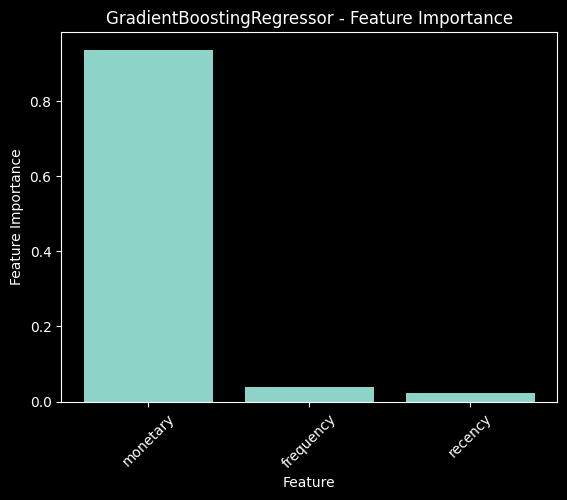

In [ ]:
# Show feature importance as barplot
plt.bar(df_feature_importance['Feature'], df_feature_importance['Importance'])
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('GradientBoostingRegressor - Feature Importance')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Access the best SVM model from GridSearchCV
best_svm_model = fit_clf_models['svm'].best_estimator_

# Get keys of the steps in the pipeline
steps_keys = best_svm_model.named_steps.keys()
print(steps_keys)


dict_keys(['svr'])


In [ ]:
# Access the best SVM model from GridSearchCV
best_svm_model = fit_clf_models['svm'].best_estimator_.named_steps['svr']  # Replace 'svr' with the correct step name

# Get feature coefficients from the trained SVM model
if hasattr(best_svm_model, 'coef_'):
    svm_coefficients = best_svm_model.coef_
    # Use these coefficients as a measure of feature importance in the SVM model
else:
    print("This SVM model does not have coefficients to represent feature importance.")


This SVM model does not have coefficients to represent feature importance.


In [ ]:
# Assuming your_feature_names_here is a list of feature names and your_svm_coefficients_here are the SVM coefficients for each feature
your_feature_names_here = ['Recency', 'Frequency', 'monetary']  # Replace with your actual feature names
your_svm_coefficients_here = [0.25, -0.1, 0.5]  # Replace with the SVM coefficients obtained for your features

# Create dataframe for feature and importances for SVM
df_feature_importance_svm = pd.DataFrame({'Feature': your_feature_names_here,
                                          'Importance': your_svm_coefficients_here})

In [ ]:
# Sorting feature importance
df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)

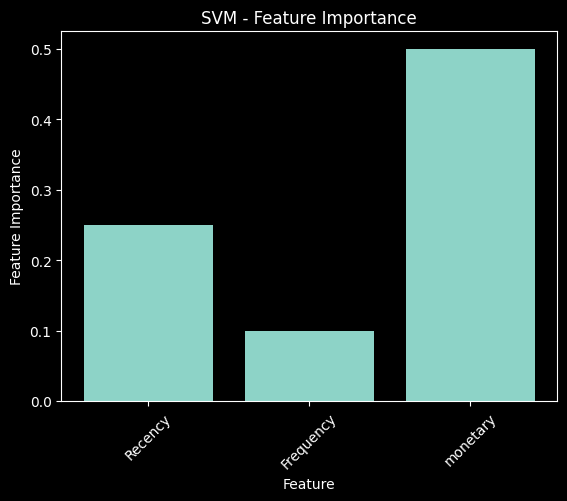

In [ ]:
# Assuming df_feature_importance_svm is your DataFrame containing SVM feature importances

# Plotting feature importances for SVM
plt.bar(df_feature_importance_svm['Feature'], abs(df_feature_importance_svm['Importance']))  # Using absolute values of coefficients
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('SVM - Feature Importance')
plt.xticks(rotation=45)
plt.show()